In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import collections
from collections import Counter
from typing import List
from scipy.stats import pearsonr
import ast
import torch
import glob
import os

### Load file

In [2]:
folder_path = "../../datasets/train/chunk_scores"

examples = []
json_files = glob.glob(os.path.join(folder_path, "*.json"))

for file_path in json_files:
    with open(file_path, "r") as f:
        data = json.load(f)
        examples.extend(data)

In [3]:
examples[0]['scores'][1].keys()

dict_keys(['prompt_attention_score', 'r_span', 'hallucination_label', 'parameter_knowledge_scores'])

### Create subsets of Truthful and Hallucinated

In [4]:
ecs_truthful = collections.defaultdict(list)
ecs_hallucinated = collections.defaultdict(list)
pks_truthful = collections.defaultdict(list)
pks_hallucinated = collections.defaultdict(list)

for example in examples:
    for score in example['scores']:
        if score['hallucination_label']==0:
            for k, v in score['prompt_attention_score'].items():
                ecs_truthful[k].append(v)
            for k, v in score['parameter_knowledge_scores'].items():
                pks_truthful[k].append(v)
        else:
            for k, v in score['prompt_attention_score'].items():
                ecs_hallucinated[k].append(v)
            for k, v in score['parameter_knowledge_scores'].items():
                pks_hallucinated[k].append(v)

        

### Compute quanities

In [5]:
def pearson_corr(
    attention_scores: List[float],
    hallucination_labels: List[int],
    inverse=False
):
    if len(attention_scores) != len(hallucination_labels):
        raise ValueError("Lists must have the same length.")
    
    scores = np.array(attention_scores, dtype=float)
    labels = np.array(hallucination_labels, dtype=int)

    if not np.isin(labels, [0, 1]).all():
        raise ValueError("Hallucination labels must be 0 or 1.")

    if inverse:

        inverse_labels = 1 - labels  # invert 0<->1
        
        r, p_value = pearsonr(scores, inverse_labels)
    else:
        r, p_value = pearsonr(scores, labels)

    return r, p_value


def pearson_corr_float(x, y):
    if len(x) != len(y):
        raise ValueError("Lists must have the same length")
    if len(x) < 2:
        raise ValueError("At least two data points are required")
    
    corr, p_value = pearsonr(x, y)
    return corr, p_value

In [6]:
# I. Compute Difference of ECS (Truth - Hallucination)
ecs_diff = {}
for k, v in ecs_truthful.items():
    mean_truthful = np.mean(v)
    mean_hallucinated = np.mean(ecs_hallucinated[k])
    ecs_diff[k] = mean_truthful - mean_hallucinated

# II. Compute Pearson's r: ECS vs. Inverse Hallucination Label
ecs_lst = collections.defaultdict(list) 
ecs_label_lst = collections.defaultdict(list) 
for k, v in ecs_truthful.items():
    for a in v:
        ecs_lst[k].append(a)
        ecs_label_lst[k].append(0)
    for a in ecs_hallucinated[k]:
        ecs_lst[k].append(a)
        ecs_label_lst[k].append(1)

ecs_pcc = {}
for k, v in ecs_lst.items():
    r, p_val = pearson_corr(v, ecs_label_lst[k], inverse=True)
    ecs_pcc[k] = r

# III. Load coping head score# Load tensor.json
with open("../../datasets/OV_copying_score.json", "r") as f:
    data = json.load(f)  # This is now a nested Python list

# Convert to tensor (optional)
tensor = torch.tensor(data)

# Build dictionary {(row,col): value}
copying_dict = {f"({i},{j})": float(tensor[i, j]) 
               for i in range(tensor.size(0)) 
               for j in range(tensor.size(1))}

# IV. Compute Difference of PKS (Truth - Hallucination)
pks_diff = {}
for k, v in pks_truthful.items():
    mean_truthful = np.mean(v)
    mean_hallucinated = np.mean(pks_hallucinated[k])
    pks_diff[k] = mean_hallucinated - mean_truthful
    

# V. Compute Pearson's r: PKS vs. Hallucination Label
pks_lst = collections.defaultdict(list) 
pks_label_lst = collections.defaultdict(list) 
for k, v in pks_truthful.items():
    for a in v:
        pks_lst[k].append(a)
        pks_label_lst[k].append(0)
    for a in pks_hallucinated[k]:
        pks_lst[k].append(a)
        pks_label_lst[k].append(1)

pks_pcc = {}
for k, v in pks_lst.items():
    r, p_val = pearson_corr(v, pks_label_lst[k], inverse=False)
    pks_pcc[k] = r


### Plot

### - External Content

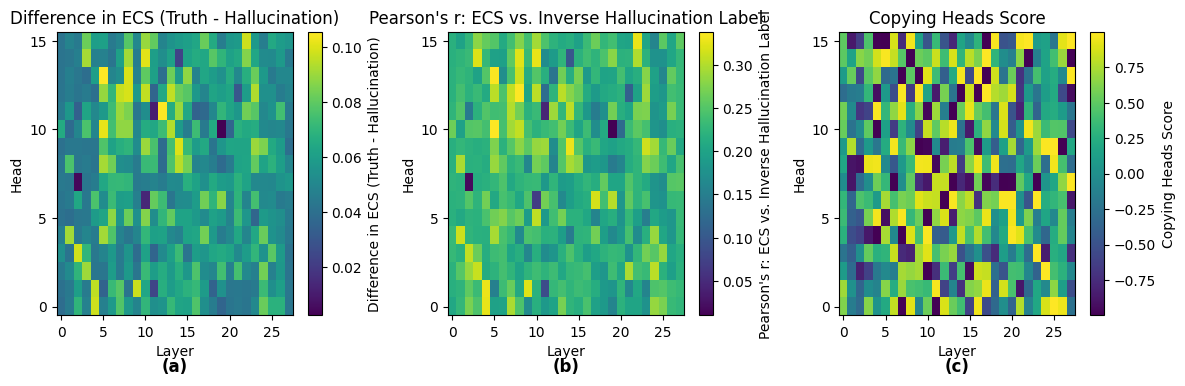

In [7]:
# Parse keys to find layer and head ranges
# pairs = [eval(k) for k in ecs_diff.keys()]  # converts '(0, 0)' → (0, 0)
# layers = sorted(set(p[0] for p in pairs))
# heads = sorted(set(p[1] for p in pairs))

n_layers = 28 #max(layers) + 1
n_heads = 16 #max(heads) + 1

def plot_heatmap(ax, data_dict, heads=n_heads, layers=n_layers, title="Heatmap", label=""):
    
    # Convert dictionary to 2D numpy array
    arr = np.zeros((heads, layers))
    for k, value in data_dict.items():
        kk = ast.literal_eval(k)
        layer, head = kk[0], kk[1]
        arr[head, layer] = value

    # Plot heatmap
    im = ax.imshow(arr, aspect="auto", origin="lower", cmap="viridis")
    plt.colorbar(im, label=title)
    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel("Head")
    ax.set_xticks(range(0, n_layers+1, 5), range(0, n_layers+1, 5))
    ax.set_yticks(range(0, n_heads+1, 5), range(0, n_heads+1, 5))

    # Add subplot label at the bottom center
    if label is not None:
        ax.text(0.5, -0.15, label, transform=ax.transAxes,
                fontsize=12, fontweight="bold", va="top", ha="center")

    return im  # return image object for shared colorbar if needed

# Create 1 row with 3 columns
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot each dictionary
plot_heatmap(axes[0], ecs_diff, n_heads, n_layers, "Difference in ECS (Truth - Hallucination)", "(a)")
plot_heatmap(axes[1], ecs_pcc, n_heads, n_layers, "Pearson's r: ECS vs. Inverse Hallucination Label", "(b)")
plot_heatmap(axes[2], copying_dict, n_heads, n_layers, "Copying Heads Score", "(c)")

plt.tight_layout()
plt.show()


In [8]:
r1, _ = pearson_corr_float(list(ecs_diff.values()), list(copying_dict.values()))
r2, _ = pearson_corr_float(list(ecs_pcc.values()), list(copying_dict.values()))

print(r1, r2)

0.040084681304081125 -0.061841418594003


### - Parametric Knowledge

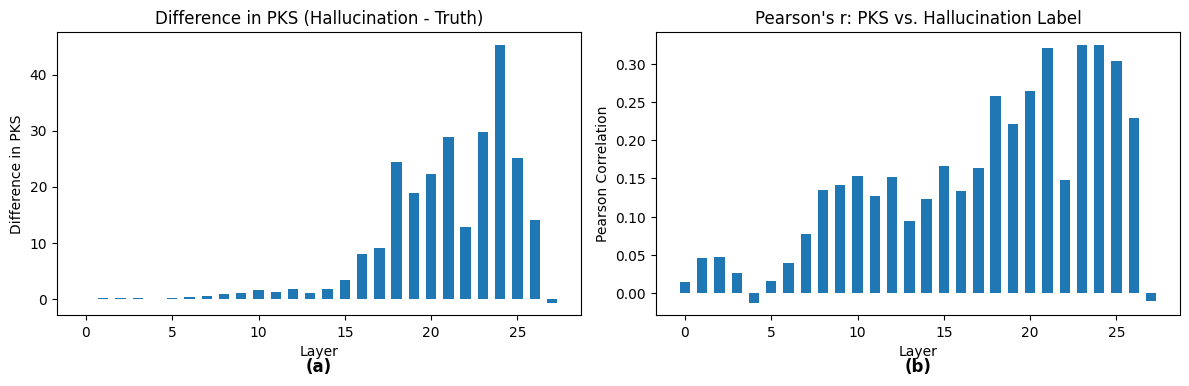

In [9]:
def plot_1d(ax, data_dict, heads=n_heads, layers=n_layers, ylabel="y", title="1d plot", label=""):
    
    # Convert dictionary to 2D numpy array
    layers = [int(k.split('_')[1]) for k in data_dict.keys()]
    values = list(data_dict.values())

    # Plot 1d
    ax.bar(layers, values, width=0.6, align='center')
    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(0, n_layers+1, 5), range(0, n_layers+1, 5))
    #ax.set_yticks(range(0, n_heads+1, 5), range(0, n_heads+1, 5))

    # Add subplot label at the bottom center
    if label is not None:
        ax.text(0.5, -0.15, label, transform=ax.transAxes,
                fontsize=12, fontweight="bold", va="top", ha="center")

# Create 1 row with 3 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot each dictionary
plot_1d(axes[0], pks_diff, n_heads, n_layers, "Difference in PKS", "Difference in PKS (Hallucination - Truth)", "(a)")
plot_1d(axes[1], pks_pcc, n_heads, n_layers, "Pearson Correlation", "Pearson's r: PKS vs. Hallucination Label", "(b)")


plt.tight_layout()
plt.show()


In [16]:
sorted_ecs_pcc = dict(sorted(ecs_pcc.items(), key=lambda x: x[1], reverse=True))

cnt = 0
for k, v in sorted_ecs_pcc.items():
    print(k, v)
    cnt += 1
    if cnt==10:
        break

(5, 10) 0.3377837756550394
(8, 12) 0.337100212134133
(5, 13) 0.33598952116247965
(4, 1) 0.3283365386150892
(14, 9) 0.32775603109772333
(10, 14) 0.3272368369352148
(22, 15) 0.32643050538935464
(4, 0) 0.32614386523500244
(8, 14) 0.3228736628962541
(9, 1) 0.3215353690478668


In [17]:
sorted_pks_pcc = dict(sorted(pks_pcc.items(), key=lambda x: x[1], reverse=True))

cnt = 0
for k, v in sorted_pks_pcc.items():
    print(k, v)
    cnt += 1
    if cnt==10:
        break

layer_24 0.32457176519398456
layer_23 0.32429551911150706
layer_21 0.3209976452482922
layer_25 0.3033466562685133
layer_20 0.26386555525744004
layer_18 0.25777323446309636
layer_26 0.2294159876336381
layer_19 0.2215290507657933
layer_15 0.16586113919539747
layer_17 0.16316090227428728
